## How to predict next Bitcoin Exchange rate

This notebook tries to find different ML models to predict the price of bitcoin, specially the direction (whether the price increased or decreased and the model predicted it correctly, not paying so much attention to the actual value).

In [ ]:
pip install requests

# Explortory Data Analysis

In [1]:
#loading the data
import pandas as pd

#https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

history = pd.read_csv("BTC-USD (3).csv")
history

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3342,2023-11-11,37310.070313,37407.093750,36773.667969,37138.050781,37138.050781,13924272142
3343,2023-11-12,37133.992188,37227.691406,36779.117188,37054.519531,37054.519531,11545715999
3344,2023-11-13,37070.304688,37405.117188,36399.605469,36502.355469,36502.355469,19057712790
3345,2023-11-14,36491.789063,36753.351563,34948.500000,35537.640625,35537.640625,23857403554


[457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985 423.204987 411.574005 404.424988]


Text(0, 0.5, 'USD')

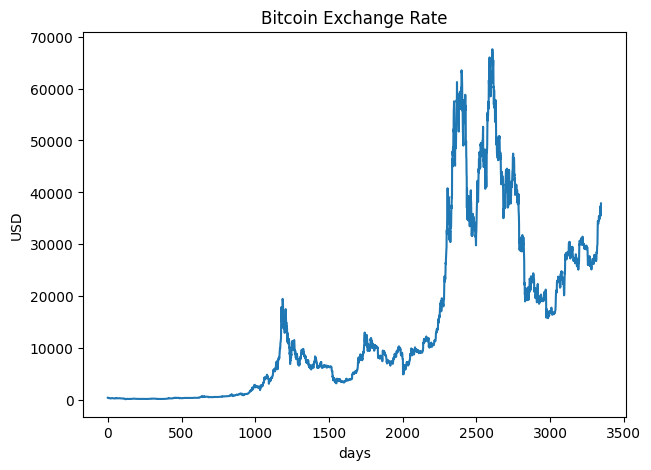

In [2]:
#plotting the data

import numpy as np
import matplotlib.pyplot as plt

BTC = np.array(history["Adj Close"])
print(BTC[:10])

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(BTC)
ax.set_title("Bitcoin Exchange Rate")
ax.set_xlabel("days")
ax.set_ylabel("USD")

In [ ]:
#printing the last year of the data
history_last_365 = history[-365:]
history_last_365

,Date,Open,High,Low,Close,Adj Close,Volume
2982,2022-11-16,16884.341797,16960.294922,16430.111328,16669.439453,16669.439453,33925512989
2983,2022-11-17,16670.425781,16726.439453,16460.683594,16687.517578,16687.517578,27868914022
2984,2022-11-18,16687.912109,16947.058594,16564.611328,16697.777344,16697.777344,26862218609
2985,2022-11-19,16696.220703,16797.876953,16570.410156,16711.546875,16711.546875,16106223492
2986,2022-11-20,16712.919922,16746.779297,16248.692383,16291.832031,16291.832031,21313378652
...,...,...,...,...,...,...,...
3342,2023-11-11,37310.070313,37407.093750,36773.667969,37138.050781,37138.050781,13924272142
3343,2023-11-12,37133.992188,37227.691406,36779.117188,37054.519531,37054.519531,11545715999
3344,2023-11-13,37070.304688,37405.117188,36399.605469,36502.355469,36502.355469,19057712790
3345,2023-11-14,36491.789063,36753.351563,34948.500000,35537.640625,35537.640625,23857403554


# Building the model

After finding the best hyperparameters, now, I try to build a model that predicts the best.

In [ ]:
# using bagging in LSTM to see if the prediction improves.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = np.concatenate((prices, features), axis=1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train individual neural network models
models = []
num_models = 5  # Adjust as needed

for _ in range(num_models):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

    models.append(model)

# Make predictions with individual models
individual_predictions = np.array([model.predict(X_test) for model in models])

# Ensemble predictions using the mean
ensemble_predictions = np.mean(individual_predictions, axis=0)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
print(f"Ensemble Mean Squared Error: {ensemble_mse}")

# Training Set Metrics
train_individual_predictions = np.array([model.predict(X_train) for model in models])
train_ensemble_predictions = np.mean(train_individual_predictions, axis=0)

train_mse = mean_squared_error(y_train, train_ensemble_predictions)
train_directional_accuracy = np.sum(np.sign(y_train[1:] - y_train[:-1]) ==
                                    np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1])) / len(y_train)



# Test Set Metrics
test_individual_predictions = np.array([model.predict(X_test) for model in models])
test_ensemble_predictions = np.mean(test_individual_predictions, axis=0)

test_mse = mean_squared_error(y_test, test_ensemble_predictions)
test_directional_accuracy = np.sum(np.sign(y_test[1:] - y_test[:-1]) ==
                                   np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1])) / len(y_test)



# Print Results for Training Set
print("\nTraining Set Metrics with Ensemble:")
print(f"Mean Squared Error: {train_mse}")
print(f"Directional Accuracy: {train_directional_accuracy * 100}%")

# Print Results for Test Set
print("\nTest Set Metrics with Ensemble:")
print(f"Mean Squared Error: {test_mse}")
print(f"Directional Accuracy: {test_directional_accuracy * 100}%")



Epoch 1/20
150/150 [==============================] - 65s 405ms/step - loss: 0.0046
Epoch 2/20
150/150 [==============================] - 61s 407ms/step - loss: 0.0021
Epoch 3/20
150/150 [==============================] - 62s 414ms/step - loss: 0.0018
Epoch 4/20
150/150 [==============================] - 61s 405ms/step - loss: 0.0013
Epoch 5/20
150/150 [==============================] - 61s 404ms/step - loss: 0.0011
Epoch 6/20
150/150 [==============================] - 61s 407ms/step - loss: 0.0012
Epoch 7/20
150/150 [==============================] - 60s 401ms/step - loss: 0.0010
Epoch 8/20
150/150 [==============================] - 61s 406ms/step - loss: 0.0012
Epoch 9/20
150/150 [==============================] - 60s 403ms/step - loss: 9.4820e-04
Epoch 10/20
150/150 [==============================] - 60s 403ms/step - loss: 9.0149e-04
Epoch 11/20
150/150 [==============================] - 61s 404ms/step - loss: 9.8135e-04
Epoch 12/20
150/150 [==============================] - 60s 402

In [ ]:
# using ensamble methods (random forest and LSTM) to see if the predictions improve

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
# data_combined = np.concatenate((prices, features), axis=1)
data_combined=prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create a moving window (sequence) to predict the value of price
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs= -1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get predictions from the Random Forest model
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_test_predictions = rf_model.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])

# Continue with the LSTM model training
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with more epochs
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping])

# Get predictions from the LSTM model
lstm_train_predictions = model.predict(X_train)
lstm_test_predictions = model.predict(X_test)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([lstm_train_predictions.reshape(-1, 1), rf_train_predictions.reshape(-1, 1)], axis=0)
test_ensemble_predictions = np.mean([lstm_test_predictions.reshape(-1, 1), rf_test_predictions.reshape(-1, 1)], axis=0)

# Calculate Metrics for Training Set
train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Metrics for LSTM model on the training set
train_lstm_predictions = model.predict(X_train)
train_lstm_predictions = scaler.inverse_transform(train_lstm_predictions)

# Metrics for Random Forest model on the training set
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_train_predictions = rf_train_predictions.reshape(-1, 1)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([train_lstm_predictions, rf_train_predictions], axis=0)

# Evaluate ensemble performance on the training set
ensemble_train_mse = mean_squared_error(train_actual_prices, train_ensemble_predictions)
ensemble_train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                              np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1])) / len(
    train_actual_prices)
ensemble_train_conf_matrix = confusion_matrix(
    np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
    np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the training set
ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[0, 1])
ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[1, 0])

# Profit/Loss Analysis for training set
ensemble_train_profit_loss = 0
for i in range(1, len(train_actual_prices)):
    if np.sign(train_ensemble_predictions[i] - train_ensemble_predictions[i - 1]) == np.sign(
            train_actual_prices[i] - train_actual_prices[i - 1]):
        ensemble_train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

# Calculate Error Rate
ensemble_train_error_rate = 1 - ensemble_train_directional_accuracy

# Predictions for the test set
test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics for LSTM model on the test set
test_lstm_predictions = model.predict(X_test)
test_lstm_predictions = scaler.inverse_transform(test_lstm_predictions)

# Reshape input data for RandomForestRegressor on the test set
X_test_rf = np.reshape(X_test, (X_test.shape[0], -1))

# Metrics for Random Forest model on the test set
rf_test_predictions = rf_model.predict(X_test_rf[:, 1:])
rf_test_predictions = rf_test_predictions.reshape(-1, 1)

# Combine predictions using averaging
test_ensemble_predictions = np.mean([test_lstm_predictions, rf_test_predictions], axis=0)

# Evaluate ensemble performance on the test set
ensemble_test_mse = mean_squared_error(test_actual_prices, test_ensemble_predictions)
ensemble_test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                             np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1])) / len(
    test_actual_prices)
ensemble_test_conf_matrix = confusion_matrix(
    np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
    np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the test set
ensemble_test_precision = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[0, 1])
ensemble_test_recall = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[1, 0])

# Profit/Loss Analysis for the test set
ensemble_test_profit_loss = 0
for i in range(1, len(test_actual_prices)):
    if np.sign(test_ensemble_predictions[i] - test_ensemble_predictions[i - 1]) == np.sign(
            test_actual_prices[i] - test_actual_prices[i - 1]):
        ensemble_test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

# Calculate Error Rate for the test set
ensemble_test_error_rate = 1 - ensemble_test_directional_accuracy

# Print Results for Training Set
print("\nTraining Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_train_mse}")
print(f"Directional Accuracy: {ensemble_train_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_train_conf_matrix)
print(f"Precision: {ensemble_train_precision}")
print(f"Recall: {ensemble_train_recall}")
print(f"Profit/Loss: {ensemble_train_profit_loss}")
print(f"Error Rate: {ensemble_train_error_rate * 100}%")

# Print Results for Test Set
print("\nTest Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_test_mse}")
print(f"Directional Accuracy: {ensemble_test_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_test_conf_matrix)
print(f"Precision: {ensemble_test_precision}")
print(f"Recall: {ensemble_test_recall}")
print(f"Profit/Loss: {ensemble_test_profit_loss}")
print(f"Error Rate: {ensemble_test_error_rate * 100}%")



Epoch 1/20
150/150 [==============================] - 103s 647ms/step - loss: 0.0046
Epoch 2/20
150/150 [==============================] - 96s 643ms/step - loss: 0.0016
Epoch 3/20
150/150 [==============================] - 95s 637ms/step - loss: 0.0017
Epoch 4/20
150/150 [==============================] - 96s 635ms/step - loss: 0.0013
Epoch 5/20
150/150 [==============================] - 96s 641ms/step - loss: 0.0013
Epoch 6/20
150/150 [==============================] - 96s 640ms/step - loss: 0.0013
Epoch 7/20
150/150 [==============================] - 94s 629ms/step - loss: 0.0011
Epoch 8/20
150/150 [==============================] - 96s 642ms/step - loss: 8.4823e-04
Epoch 9/20
150/150 [==============================] - 96s 639ms/step - loss: 9.3050e-04
Epoch 10/20
150/150 [==============================] - 97s 646ms/step - loss: 7.7284e-04
Epoch 11/20
150/150 [==============================] - 96s 636ms/step - loss: 8.3842e-04
Epoch 12/20
150/150 [==============================] - 96

<ipython-input-9-1ebf15084103>:113: RuntimeWarning: invalid value encountered in long_scalars
  ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (
<ipython-input-9-1ebf15084103>:115: RuntimeWarning: invalid value encountered in long_scalars
  ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (


19/19 [==============================] - 4s 207ms/step

Training Set Metrics with Ensemble:
Mean Squared Error: 128510296.82548094
Directional Accuracy: 62.95054484492874%
Confusion Matrix:
[[607   0 466]
 [  0   0   1]
 [416   0 895]]
Precision: nan
Recall: nan
Profit/Loss: [48540.823072]
Error Rate: 37.04945515507126%

Test Set Metrics with Ensemble:
Mean Squared Error: 186677319.8393333
Directional Accuracy: 62.14405360134003%
Confusion Matrix:
[[203 114]
 [111 168]]


In [ ]:
# ensamble methods with LSTM, Random Forest and GRU (Gated Recurrent Unit)

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping

import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create a moving window (sequence) to predict the value of price
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get predictions from the Random Forest model
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_test_predictions = rf_model.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])

# Continue with the LSTM model training
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_lstm = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the LSTM model with more epochs
model_lstm.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping_lstm])

# Get predictions from the LSTM model
lstm_train_predictions = model_lstm.predict(X_train)
lstm_test_predictions = model_lstm.predict(X_test)

# Continue with the GRU model training
model_gru = Sequential()
model_gru.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=100, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_gru = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the GRU model with more epochs
model_gru.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping_gru])

# Get predictions from the GRU model
gru_train_predictions = model_gru.predict(X_train)
gru_test_predictions = model_gru.predict(X_test)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([lstm_train_predictions.reshape(-1, 1),
                                      rf_train_predictions.reshape(-1, 1),
                                      gru_train_predictions.reshape(-1, 1)], axis=0)
test_ensemble_predictions = np.mean([lstm_test_predictions.reshape(-1, 1),
                                     rf_test_predictions.reshape(-1, 1),
                                     gru_test_predictions.reshape(-1, 1)], axis=0)


# Calculate Metrics for Training Set
train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Metrics for LSTM model on the training set
train_lstm_predictions = model_lstm.predict(X_train)
train_lstm_predictions = scaler.inverse_transform(train_lstm_predictions)

# Metrics for GRU model on the training set
gru_train_predictions = model_gru.predict(X_train)
gru_train_predictions = scaler.inverse_transform(gru_train_predictions)

# Metrics for Random Forest model on the training set
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_train_predictions = rf_train_predictions.reshape(-1, 1)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([train_lstm_predictions, gru_train_predictions, rf_train_predictions], axis=0)

# Evaluate ensemble performance on the training set
ensemble_train_mse = mean_squared_error(train_actual_prices, train_ensemble_predictions)
ensemble_train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                              np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1])) / len(
    train_actual_prices)
ensemble_train_conf_matrix = confusion_matrix(
    np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
    np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the training set
ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[0, 1])
ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[1, 0])

# Profit/Loss Analysis for training set
ensemble_train_profit_loss = 0
for i in range(1, len(train_actual_prices)):
    if np.sign(train_ensemble_predictions[i] - train_ensemble_predictions[i - 1]) == np.sign(
            train_actual_prices[i] - train_actual_prices[i - 1]):
        ensemble_train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

# Calculate Error Rate
ensemble_train_error_rate = 1 - ensemble_train_directional_accuracy

# Predictions for the test set
test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics for LSTM model on the test set
test_lstm_predictions = model_lstm.predict(X_test)
test_lstm_predictions = scaler.inverse_transform(test_lstm_predictions)

# Metrics for GRU model on the test set
gru_test_predictions = model_gru.predict(X_test)
gru_test_predictions = scaler.inverse_transform(gru_test_predictions)

# Reshape input data for RandomForestRegressor on the test set
X_test_rf = np.reshape(X_test, (X_test.shape[0], -1))

# Metrics for Random Forest model on the test set
rf_test_predictions = rf_model.predict(X_test_rf[:, 1:])
rf_test_predictions = rf_test_predictions.reshape(-1, 1)

# Combine predictions using averaging
test_ensemble_predictions = np.mean([test_lstm_predictions, gru_test_predictions, rf_test_predictions], axis=0)

# Evaluate ensemble performance on the test set
ensemble_test_mse = mean_squared_error(test_actual_prices, test_ensemble_predictions)
ensemble_test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                             np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1])) / len(
    test_actual_prices)
ensemble_test_conf_matrix = confusion_matrix(
    np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
    np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the test set
ensemble_test_precision = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[0, 1])
ensemble_test_recall = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[1, 0])

# Profit/Loss Analysis for the test set
ensemble_test_profit_loss = 0
for i in range(1, len(test_actual_prices)):
    if np.sign(test_ensemble_predictions[i] - test_ensemble_predictions[i - 1]) == np.sign(
            test_actual_prices[i] - test_actual_prices[i - 1]):
        ensemble_test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

# Calculate Error Rate for the test set
ensemble_test_error_rate = 1 - ensemble_test_directional_accuracy

# Print Results for Training Set
print("\nTraining Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_train_mse}")
print(f"Directional Accuracy: {ensemble_train_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_train_conf_matrix)
print(f"Precision: {ensemble_train_precision}")
print(f"Recall: {ensemble_train_recall}")
print(f"Profit/Loss: {ensemble_train_profit_loss}")
print(f"Error Rate: {ensemble_train_error_rate * 100}%")

# Print Results for Test Set
print("\nTest Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_test_mse}")
print(f"Directional Accuracy: {ensemble_test_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_test_conf_matrix)
print(f"Precision: {ensemble_test_precision}")
print(f"Recall: {ensemble_test_recall}")
print(f"Profit/Loss: {ensemble_test_profit_loss}")
print(f"Error Rate: {ensemble_test_error_rate * 100}%")



Epoch 1/20
150/150 [==============================] - 107s 632ms/step - loss: 0.0044
Epoch 2/20
150/150 [==============================] - 91s 605ms/step - loss: 0.0019
Epoch 3/20
150/150 [==============================] - 91s 610ms/step - loss: 0.0014
Epoch 4/20
150/150 [==============================] - 91s 609ms/step - loss: 0.0014
Epoch 5/20
150/150 [==============================] - 90s 603ms/step - loss: 0.0014
Epoch 6/20
150/150 [==============================] - 91s 604ms/step - loss: 0.0011
Epoch 7/20
150/150 [==============================] - 90s 601ms/step - loss: 0.0011
Epoch 8/20
150/150 [==============================] - 90s 603ms/step - loss: 9.6559e-04
Epoch 9/20
150/150 [==============================] - 92s 612ms/step - loss: 0.0013
Epoch 10/20
150/150 [==============================] - 90s 597ms/step - loss: 0.0010
Epoch 11/20
150/150 [==============================] - 90s 603ms/step - loss: 9.2194e-04
Epoch 12/20
150/150 [==============================] - 92s 617ms/

KeyboardInterrupt: ignored

At the beginning I didn't set a seed because I wanted the model to explore different routes and by doing so, the second time it ran, I got up to 78% of directional accuracy on the test set (results below), however, I interrupted the execution of the code above since it never got that results again. Therefore, I decided to set the seed for reproducibility later on.


Training Set Metrics with Ensemble:
Mean Squared Error: 58773609.841935076
Directional Accuracy: 68.14752724224644%
Confusion Matrix:
[[670   0 403]
 [  0   0   1]
 [355   0 956]]
Precision: nan
Recall: nan
Profit/Loss: [54879.380994]
Error Rate: 31.85247275775356%

Test Set Metrics with Ensemble:
Mean Squared Error: 85549846.89032555
Directional Accuracy: 67.33668341708542%
Confusion Matrix:
[[216 101]
 [ 93 186]]
Precision: 0.6480836236933798
Recall: 0.6666666666666666
Profit/Loss: [-17523.322267]
Error Rate: 32.66331658291457%

Results of second time it runs:

Training Set Metrics with Ensemble:
Mean Squared Error: 48973205.5811657
Directional Accuracy: 77.78709136630344%
Confusion Matrix:
[[ 787    0  286]
 [   0    0    1]
 [ 242    0 1069]]
Precision: nan
Recall: nan
Profit/Loss: [49995.219245]
Error Rate: 22.21290863369656%

Test Set Metrics with Ensemble:
Mean Squared Error: 70572361.42356756
Directional Accuracy: 78.05695142378559%
Confusion Matrix:
[[248  69]
 [ 61 218]]
Precision: 0.759581881533101
Recall: 0.7813620071684588
Profit/Loss: [-9461.606444]
Error Rate: 21.94304857621441%


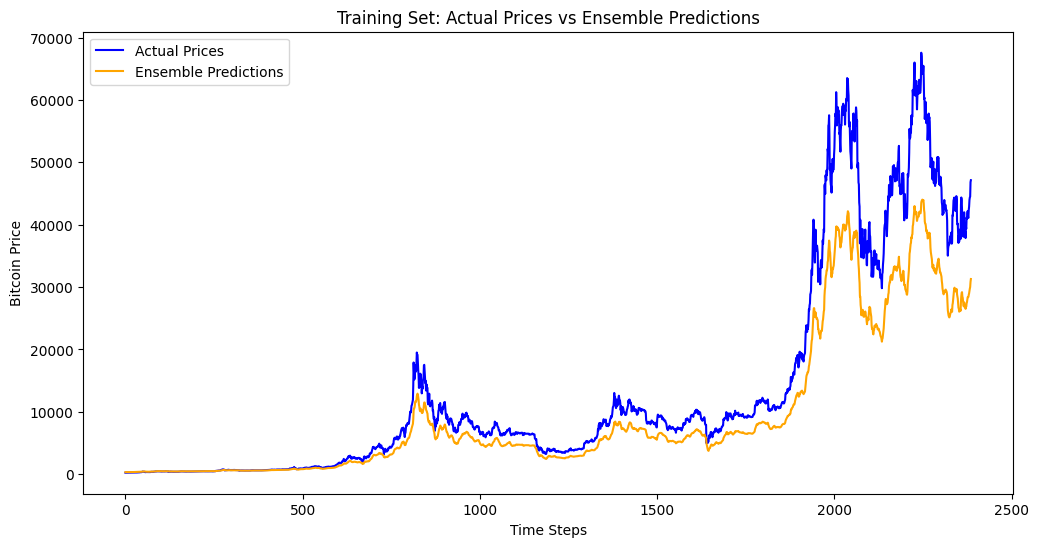

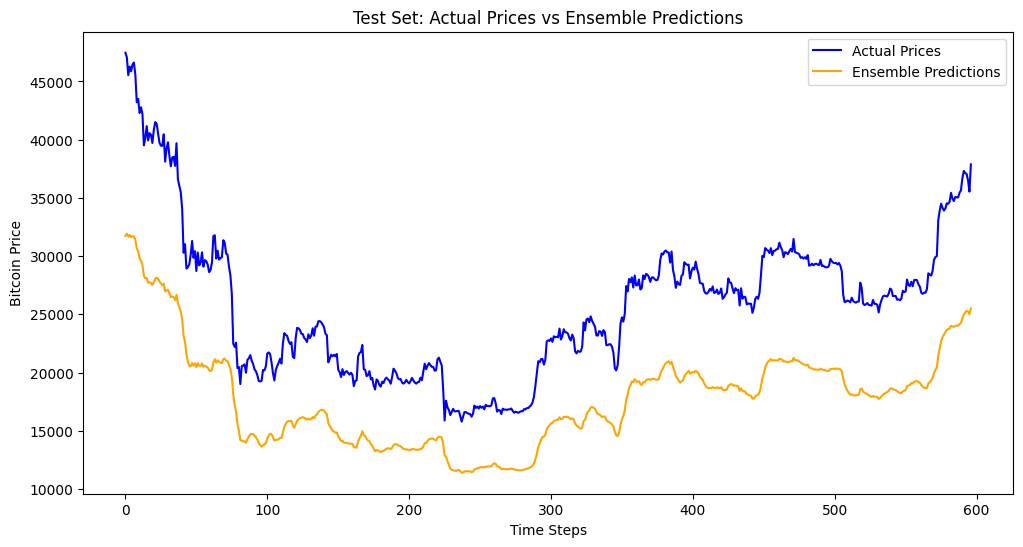

In [ ]:
# plotting the predictions from the ensemble model above

# Import necessary libraries
import matplotlib.pyplot as plt

# Plot real and predicted values for training set
plt.figure(figsize=(12, 6))
plt.plot(train_actual_prices, label='Actual Prices', color='blue')
plt.plot(train_ensemble_predictions, label='Ensemble Predictions', color='orange')
plt.title('Training Set: Actual Prices vs Ensemble Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# Plot real and predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(test_actual_prices, label='Actual Prices', color='blue')
plt.plot(test_ensemble_predictions, label='Ensemble Predictions', color='orange')
plt.title('Test Set: Actual Prices vs Ensemble Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


In [ ]:
# changing hyperparameters to see if the model improves
# ensamble methods with LSTM, Random Forest and GRU (Gated Recurrent Unit)

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping
from torch.optim import AdamW

# stablish hyperparameters

# number of trees for random forest
n_estimators_rf = 150
# Training LSTM with units=100, dropout=0.2, epochs=30, batch_size=8
# number of neurons for each hidden layer of the LSTM
units = 100
dropout = 0.2
epochs = 30
batch_size = 8
# Training GRU with units=100, dropout=0.2, epochs=20, batch_size=8
units_gru=100
dropout_gru=0.2
epochs_gru=20
batch_size_gru=8


n_estimators_xgb=100


# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create a moving window (sequence) to predict the value of price
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=n_estimators_rf, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get predictions from the Random Forest model
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_test_predictions = rf_model.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])

# Continue with the LSTM model training
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(dropout))
model_lstm.add(LSTM(units=units, return_sequences=True))
model_lstm.add(Dropout(dropout))
model_lstm.add(LSTM(units=units))
model_lstm.add(Dropout(dropout))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_lstm = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the LSTM model with more epochs
model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping_lstm])

# Get predictions from the LSTM model
lstm_train_predictions = model_lstm.predict(X_train)
lstm_test_predictions = model_lstm.predict(X_test)

# Continue with the GRU model training
model_gru = Sequential()
model_gru.add(GRU(units=units_gru, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(dropout_gru))
model_gru.add(GRU(units=units_gru, return_sequences=True))
model_gru.add(Dropout(dropout_gru))
model_gru.add(GRU(units=units_gru))
model_gru.add(Dropout(dropout_gru))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_gru = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the GRU model with more epochs
model_gru.fit(X_train, y_train, epochs=epochs_gru, batch_size=batch_size_gru, verbose=1, callbacks=[early_stopping_gru])

# Get predictions from the GRU model
gru_train_predictions = model_gru.predict(X_train)
gru_test_predictions = model_gru.predict(X_test)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([lstm_train_predictions.reshape(-1, 1),
                                      rf_train_predictions.reshape(-1, 1),
                                      gru_train_predictions.reshape(-1, 1)], axis=0)
test_ensemble_predictions = np.mean([lstm_test_predictions.reshape(-1, 1),
                                     rf_test_predictions.reshape(-1, 1),
                                     gru_test_predictions.reshape(-1, 1)], axis=0)


# Calculate Metrics for Training Set
train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Metrics for LSTM model on the training set
train_lstm_predictions = model_lstm.predict(X_train)
train_lstm_predictions = scaler.inverse_transform(train_lstm_predictions)

# Metrics for GRU model on the training set
gru_train_predictions = model_gru.predict(X_train)
gru_train_predictions = scaler.inverse_transform(gru_train_predictions)

# Metrics for Random Forest model on the training set
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_train_predictions = rf_train_predictions.reshape(-1, 1)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([train_lstm_predictions, gru_train_predictions, rf_train_predictions], axis=0)

# Evaluate ensemble performance on the training set
ensemble_train_mse = mean_squared_error(train_actual_prices, train_ensemble_predictions)
ensemble_train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                              np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1])) / len(
    train_actual_prices)
ensemble_train_conf_matrix = confusion_matrix(
    np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
    np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the training set
ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[0, 1])
ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (
        ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[1, 0])

# Profit/Loss Analysis for training set
ensemble_train_profit_loss = 0
for i in range(1, len(train_actual_prices)):
    if np.sign(train_ensemble_predictions[i] - train_ensemble_predictions[i - 1]) == np.sign(
            train_actual_prices[i] - train_actual_prices[i - 1]):
        ensemble_train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

# Calculate Error Rate
ensemble_train_error_rate = 1 - ensemble_train_directional_accuracy

# Predictions for the test set
test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics for LSTM model on the test set
test_lstm_predictions = model_lstm.predict(X_test)
test_lstm_predictions = scaler.inverse_transform(test_lstm_predictions)

# Metrics for GRU model on the test set
gru_test_predictions = model_gru.predict(X_test)
gru_test_predictions = scaler.inverse_transform(gru_test_predictions)

# Reshape input data for RandomForestRegressor on the test set
X_test_rf = np.reshape(X_test, (X_test.shape[0], -1))

# Metrics for Random Forest model on the test set
rf_test_predictions = rf_model.predict(X_test_rf[:, 1:])
rf_test_predictions = rf_test_predictions.reshape(-1, 1)

# Combine predictions using averaging
test_ensemble_predictions = np.mean([test_lstm_predictions, gru_test_predictions, rf_test_predictions], axis=0)

# Evaluate ensemble performance on the test set
ensemble_test_mse = mean_squared_error(test_actual_prices, test_ensemble_predictions)
ensemble_test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                             np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1])) / len(
    test_actual_prices)
ensemble_test_conf_matrix = confusion_matrix(
    np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
    np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the test set
ensemble_test_precision = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[0, 1])
ensemble_test_recall = ensemble_test_conf_matrix[1, 1] / (
        ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[1, 0])

# Profit/Loss Analysis for the test set
ensemble_test_profit_loss = 0
for i in range(1, len(test_actual_prices)):
    if np.sign(test_ensemble_predictions[i] - test_ensemble_predictions[i - 1]) == np.sign(
            test_actual_prices[i] - test_actual_prices[i - 1]):
        ensemble_test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

# Calculate Error Rate for the test set
ensemble_test_error_rate = 1 - ensemble_test_directional_accuracy

# Print Results for Training Set
print("\nTraining Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_train_mse}")
print(f"Directional Accuracy: {ensemble_train_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_train_conf_matrix)
print(f"Precision: {ensemble_train_precision}")
print(f"Recall: {ensemble_train_recall}")
print(f"Profit/Loss: {ensemble_train_profit_loss}")
print(f"Error Rate: {ensemble_train_error_rate * 100}%")

# Print Results for Test Set
print("\nTest Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_test_mse}")
print(f"Directional Accuracy: {ensemble_test_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_test_conf_matrix)
print(f"Precision: {ensemble_test_precision}")
print(f"Recall: {ensemble_test_recall}")
print(f"Profit/Loss: {ensemble_test_profit_loss}")
print(f"Error Rate: {ensemble_test_error_rate * 100}%")




Epoch 1/30
299/299 [==============================] - 17s 38ms/step - loss: 0.0034
Epoch 2/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0018
Epoch 3/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0015
Epoch 4/30
299/299 [==============================] - 11s 38ms/step - loss: 0.0011
Epoch 5/30
299/299 [==============================] - 11s 38ms/step - loss: 0.0012
Epoch 6/30
299/299 [==============================] - 11s 38ms/step - loss: 0.0010
Epoch 7/30
299/299 [==============================] - 12s 41ms/step - loss: 0.0011
Epoch 8/30
299/299 [==============================] - 11s 38ms/step - loss: 8.7897e-04
Epoch 9/30
299/299 [==============================] - 11s 38ms/step - loss: 0.0011
Epoch 10/30
299/299 [==============================] - 14s 46ms/step - loss: 7.9401e-04
Epoch 11/30
299/299 [==============================] - 17s 57ms/step - loss: 0.0010
Epoch 12/30
299/299 [==============================] - 16s 55ms/step - loss: 

<ipython-input-5-a587d3e83cad>:170: RuntimeWarning: invalid value encountered in long_scalars
  ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (
<ipython-input-5-a587d3e83cad>:172: RuntimeWarning: invalid value encountered in long_scalars
  ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (


19/19 [==============================] - 0s 20ms/step

Training Set Metrics with Ensemble:
Mean Squared Error: 56535913.39255161
Directional Accuracy: 75.69153394803017%
Confusion Matrix:
[[ 755    0  318]
 [   0    0    1]
 [ 260    0 1051]]
Precision: nan
Recall: nan
Profit/Loss: [46027.999528]
Error Rate: 24.308466051969823%

Test Set Metrics with Ensemble:
Mean Squared Error: 83272270.95941362
Directional Accuracy: 76.88442211055276%
Confusion Matrix:
[[242  75]
 [ 62 217]]
Precision: 0.7431506849315068
Recall: 0.7777777777777778
Profit/Loss: [-12365.794923]
Error Rate: 23.115577889447238%


'\nTraining Set Metrics with Ensemble:\nMean Squared Error: 58773609.841935076\nDirectional Accuracy: 68.14752724224644%\nConfusion Matrix:\n[[670   0 403]\n [  0   0   1]\n [355   0 956]]\nPrecision: nan\nRecall: nan\nProfit/Loss: [54879.380994]\nError Rate: 31.85247275775356%\n\nTest Set Metrics with Ensemble:\nMean Squared Error: 85549846.89032555\nDirectional Accuracy: 67.33668341708542%\nConfusion Matrix:\n[[216 101]\n [ 93 186]]\nPrecision: 0.6480836236933798\nRecall: 0.6666666666666666\nProfit/Loss: [-17523.322267]\nError Rate: 32.66331658291457%\n'

After testing the model, I change the hyperparameters to those found before in the fine-tuning phase to see if the results improved, and they did. The second attempt (which is the fine-tuned hyperparameters) gave a higher directional accuracy on the test set.

First time withou hyper parameter tuning:

Training Set Metrics with Ensemble:
Mean Squared Error: 58773609.841935076
Directional Accuracy: 68.14752724224644%

Confusion Matrix:
[[670   0 403]
 [  0   0   1]
 [355   0 956]]

Precision: nan
Recall: nan
Profit/Loss: [54879.380994]
Error Rate: 31.85247275775356%

Test Set Metrics with Ensemble:
Mean Squared Error: 85549846.89032555
Directional Accuracy: 67.33668341708542%
Confusion Matrix:
[[216 101]
 [ 93 186]]
Precision: 0.6480836236933798
Recall: 0.6666666666666666
Profit/Loss: [-17523.322267]
Error Rate: 32.66331658291457%

Results after fine tunning the hyperparameters:

Training Set Metrics with Ensemble:
Mean Squared Error: 56535913.39255161
Directional Accuracy: 75.69153394803017%
Confusion Matrix:
[[ 755    0  318]
 [   0    0    1]
 [ 260    0 1051]]
Precision: nan
Recall: nan
Profit/Loss: [46027.999528]
Error Rate: 24.308466051969823%

Test Set Metrics with Ensemble:
Mean Squared Error: 83272270.95941362
Directional Accuracy: 76.88442211055276%
Confusion Matrix:
[[242  75]
 [ 62 217]]
Precision: 0.7431506849315068
Recall: 0.7777777777777778
Profit/Loss: [-12365.794923]
Error Rate: 23.115577889447238%

# Final model

Putting together what I learned from the previous experimentation (different ensemble models and fine-tunning) to build the final model.

In [4]:
# ensamble methods lstm, gru, rf, xgboost with hyperparameters tunned.




import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor

import tensorflow as tf
import random

# Hyperparameters for Random Forest
n_estimators_rf = 150

# number of neurons for each hidden layer of the LSTM
units = 100
dropout = 0.2
epochs = 30
batch_size = 8
# Training GRU with units=100, dropout=0.2, epochs=20, batch_size=8
units_gru = 100
dropout_gru = 0.2
epochs_gru = 20
batch_size_gru = 8
# estimators for xgboost
n_estimators_xgb = 100


# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create a moving window (sequence) to predict the value of the price
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=n_estimators_rf, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get predictions from the Random Forest model
rf_train_predictions = rf_model.predict(X_train_rf[:, 1:])
rf_test_predictions = rf_model.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])

# Continue with the LSTM model training
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=units, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=units))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_lstm = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the LSTM model with more epochs
model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping_lstm])

# Get predictions from the LSTM model
lstm_train_predictions = model_lstm.predict(X_train)
lstm_test_predictions = model_lstm.predict(X_test)

# Continue with the GRU model training
model_gru = Sequential()
model_gru.add(GRU(units=units_gru, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(dropout_gru))
model_gru.add(GRU(units=units_gru, return_sequences=True))
model_gru.add(Dropout(dropout_gru))
model_gru.add(GRU(units=units_gru))
model_gru.add(Dropout(dropout_gru))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping_gru = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the GRU model with more epochs
model_gru.fit(X_train, y_train, epochs=epochs_gru, batch_size=batch_size_gru, verbose=1, callbacks=[early_stopping_gru])

# Get predictions from the GRU model
gru_train_predictions = model_gru.predict(X_train)
gru_test_predictions = model_gru.predict(X_test)

# Continue with the XGBoost model training
model_xgb = XGBRegressor(n_estimators=n_estimators_xgb, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_rf[:, 1:], y_train)

# Get predictions from the XGBoost model
xgb_train_predictions = model_xgb.predict(X_train_rf[:, 1:])
xgb_test_predictions = model_xgb.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])


# Combine predictions using averaging
train_ensemble_predictions = np.mean([lstm_train_predictions.flatten(), rf_train_predictions.flatten(), gru_train_predictions.flatten(), xgb_train_predictions.flatten()], axis=0)
test_ensemble_predictions = np.mean([lstm_test_predictions.flatten(), gru_test_predictions.flatten(), rf_test_predictions.flatten(), xgb_test_predictions.flatten()], axis=0)


# Metrics for LSTM model on the training set
lstm_train_predictions = scaler.inverse_transform(lstm_train_predictions)

# Metrics for GRU model on the training set
gru_train_predictions = scaler.inverse_transform(gru_train_predictions)

# Metrics for Random Forest model on the training set
rf_train_predictions = rf_train_predictions.reshape(-1, 1)

# Calculate Metrics for Training Set
train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Metrics for XGBoost model on the training set
xgb_train_predictions = xgb_train_predictions.reshape(-1, 1)

# Combine predictions using averaging
train_ensemble_predictions = np.mean([lstm_train_predictions, rf_train_predictions, gru_train_predictions, xgb_train_predictions], axis=0)

# Evaluate ensemble performance on the training set
ensemble_train_mse = mean_squared_error(train_actual_prices, train_ensemble_predictions)
ensemble_train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                              np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1])) / len(
    train_actual_prices)
ensemble_train_conf_matrix = confusion_matrix(
    np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
    np.sign(train_ensemble_predictions[1:] - train_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the training set
ensemble_train_precision = ensemble_train_conf_matrix[1, 1] / (ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[0, 1] + 1e-6)
ensemble_train_recall = ensemble_train_conf_matrix[1, 1] / (ensemble_train_conf_matrix[1, 1] + ensemble_train_conf_matrix[1, 0] + 1e-6)

# Profit/Loss Analysis for the training set
ensemble_train_profit_loss = 0
for i in range(1, len(train_actual_prices)):
    if np.sign(train_ensemble_predictions[i] - train_ensemble_predictions[i - 1]) == np.sign(
            train_actual_prices[i] - train_actual_prices[i - 1]):
        ensemble_train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

# Calculate Error Rate
ensemble_train_error_rate = 1 - ensemble_train_directional_accuracy

# Predictions for the test set
test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics for LSTM model on the test set
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)

# Metrics for GRU model on the test set
gru_test_predictions = scaler.inverse_transform(gru_test_predictions)

# Metrics for Random Forest model on the test set
rf_test_predictions = rf_test_predictions.reshape(-1, 1)

# Metrics for XGBoost model on the test set
xgb_test_predictions = model_xgb.predict(np.reshape(X_test, (X_test.shape[0], -1))[:, 1:])
xgb_test_predictions = xgb_test_predictions.reshape(-1, 1)

# Combine predictions using averaging
test_ensemble_predictions = np.mean([lstm_test_predictions, gru_test_predictions, rf_test_predictions, xgb_test_predictions], axis=0)

# Evaluate ensemble performance on the test set
ensemble_test_mse = mean_squared_error(test_actual_prices, test_ensemble_predictions)
ensemble_test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                             np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1])) / len(
    test_actual_prices)
ensemble_test_conf_matrix = confusion_matrix(
    np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
    np.sign(test_ensemble_predictions[1:] - test_ensemble_predictions[:-1]))

# Calculate Precision and Recall for the test set
ensemble_test_precision = ensemble_test_conf_matrix[1, 1] / (ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[0, 1] + 1e-6)
ensemble_test_recall = ensemble_test_conf_matrix[1, 1] / (ensemble_test_conf_matrix[1, 1] + ensemble_test_conf_matrix[1, 0] + 1e-6)

# Profit/Loss Analysis for the test set
ensemble_test_profit_loss = 0
for i in range(1, len(test_actual_prices)):
    if np.sign(test_ensemble_predictions[i] - test_ensemble_predictions[i - 1]) == np.sign(
            test_actual_prices[i] - test_actual_prices[i - 1]):
        ensemble_test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

# Calculate Error Rate for the test set
ensemble_test_error_rate = 1 - ensemble_test_directional_accuracy

# Print Results for Training Set
print("\nTraining Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_train_mse}")
print(f"Directional Accuracy: {ensemble_train_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_train_conf_matrix)
print(f"Precision: {ensemble_train_precision}")
print(f"Recall: {ensemble_train_recall}")
print(f"Profit/Loss: {ensemble_train_profit_loss}")
print(f"Error Rate: {ensemble_train_error_rate * 100}%")

# Print Results for Test Set
print("\nTest Set Metrics with Ensemble:")
print(f"Mean Squared Error: {ensemble_test_mse}")
print(f"Directional Accuracy: {ensemble_test_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(ensemble_test_conf_matrix)
print(f"Precision: {ensemble_test_precision}")
print(f"Recall: {ensemble_test_recall}")
print(f"Profit/Loss: {ensemble_test_profit_loss}")
print(f"Error Rate: {ensemble_test_error_rate * 100}%")


Epoch 1/30
299/299 [==============================] - 21s 54ms/step - loss: 0.0042
Epoch 2/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0024
Epoch 3/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0014
Epoch 4/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0011
Epoch 5/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0013
Epoch 6/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0011
Epoch 7/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0011
Epoch 8/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0010
Epoch 9/30
299/299 [==============================] - 11s 38ms/step - loss: 0.0010
Epoch 10/30
299/299 [==============================] - 11s 38ms/step - loss: 7.4809e-04
Epoch 11/30
299/299 [==============================] - 11s 37ms/step - loss: 0.0010
Epoch 12/30
299/299 [==============================] - 11s 36ms/step - loss: 7.55

These combinations of models gave me the highest directional accuracy rate on the test set of up to 82.7% (although it is a bit strange that using the parameters given by the girdsearch gave lower results, more investigation is needed to see the differences on results.)

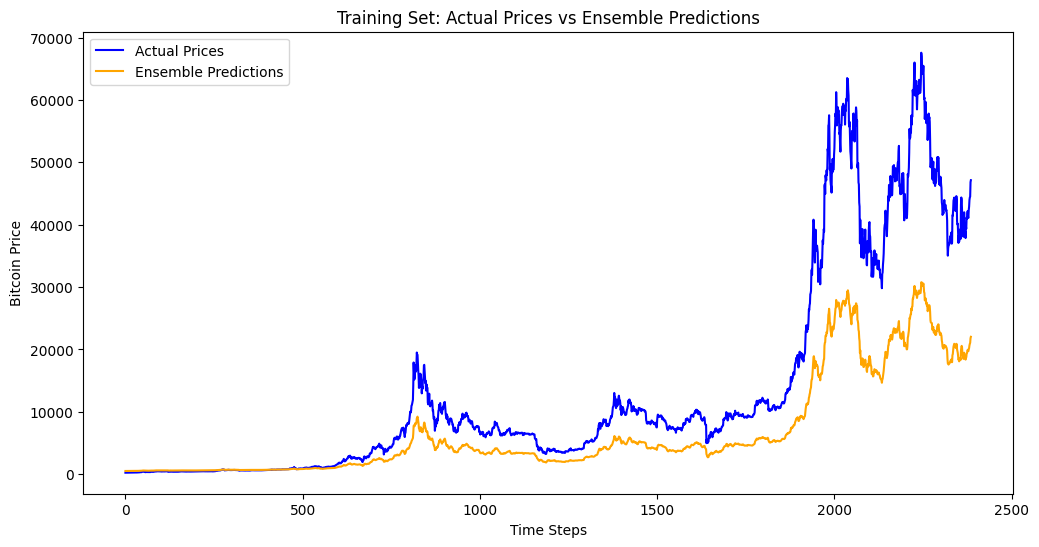

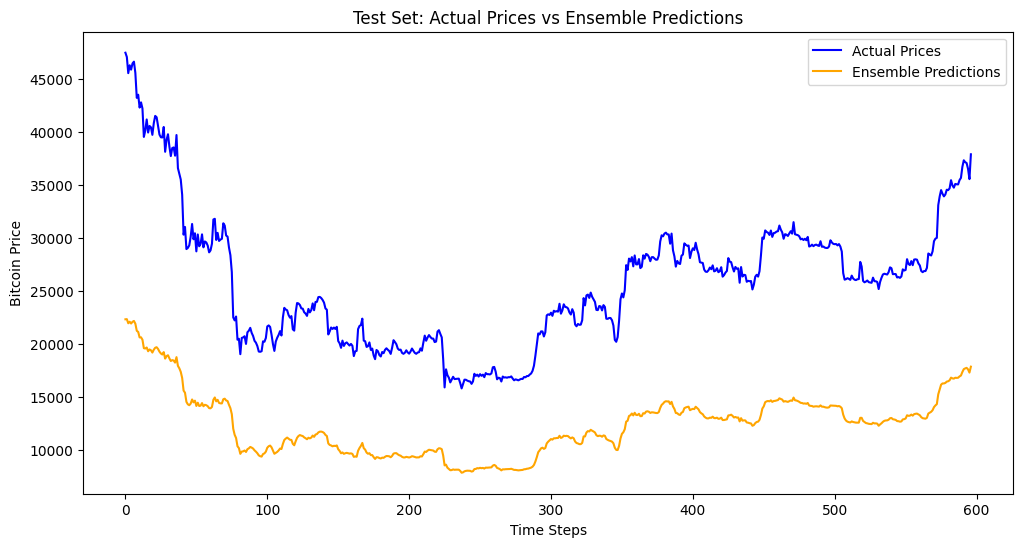

In [5]:
#plotting the above model

# Import necessary libraries
import matplotlib.pyplot as plt

# Plot real and predicted values for training set
plt.figure(figsize=(12, 6))
plt.plot(train_actual_prices, label='Actual Prices', color='blue')
plt.plot(train_ensemble_predictions, label='Ensemble Predictions', color='orange')
plt.title('Training Set: Actual Prices vs Ensemble Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# Plot real and predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(test_actual_prices, label='Actual Prices', color='blue')
plt.plot(test_ensemble_predictions, label='Ensemble Predictions', color='orange')
plt.title('Test Set: Actual Prices vs Ensemble Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


### Saving the trained models for later use.

In [ ]:
!pip install joblib


In [ ]:
from joblib import dump, load

# Save Random Forest model
dump(rf_model, "rf_model.joblib")



['rf_model.joblib']

In [ ]:
# Save LSTM model
model_lstm.save("lstm_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save GRU model
model_gru.save("gru_model.h5")



In [ ]:
# Save XGBoost model
model_xgb.save_model("xgb_model.json")


# Fine-tuning hyperparameters

### Finding the best window size, epochs, batch size, etc. for better accuracy on prediction.

In [ ]:
#Cross Validation to find the window size with the smallest MSE (range between 52-60)

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
# Assuming you have a CSV file with columns 'Date' and 'Bitcoin_Price'
data = pd.read_csv("BTC-USD.csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Set up k-fold time series cross-validation
n_splits = 5  # You can adjust the number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define a function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Function to train and evaluate the model
def train_and_evaluate(sequence_length):
    mse_scores = []
    for train_index, val_index in tscv.split(prices_scaled):
        train_data, val_data = prices_scaled[train_index], prices_scaled[val_index]

        # Create sequences for training
        X_train, y_train = create_sequences(train_data, sequence_length)
        X_val, y_val = create_sequences(val_data, sequence_length)

        # Reshape input data for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

        # Build and train the LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model on the validation set
        val_predictions = model.predict(X_val)
        mse = np.mean(np.square(val_predictions - y_val))
        mse_scores.append(mse)

    # Return the average MSE across folds
    return np.mean(mse_scores)

# Test different sequence lengths
sequence_lengths_to_test = range(52,60)

# Find the optimal sequence length
best_sequence_length = None
best_mse = float('inf')

for sequence_length in sequence_lengths_to_test:
    mse = train_and_evaluate(sequence_length)
    print(f"Sequence Length: {sequence_length}, Mean Squared Error: {mse}")

    if mse < best_mse:
        best_mse = mse
        best_sequence_length = sequence_length

print(f"Best Sequence Length: {best_sequence_length}, Best Mean Squared Error: {best_mse}")


1/1 [==============================] - 1s 923ms/step
Sequence Length: 52, Mean Squared Error: 0.005817763438227355
1/1 [==============================] - 1s 759ms/step
Sequence Length: 53, Mean Squared Error: 0.0037387942994457383
1/1 [==============================] - 1s 765ms/step
Sequence Length: 54, Mean Squared Error: 0.0042220451656968735
1/1 [==============================] - 1s 797ms/step
Sequence Length: 55, Mean Squared Error: 0.005621642207690803
1/1 [==============================] - 1s 789ms/step
Sequence Length: 56, Mean Squared Error: 0.0038661883733026926
1/1 [==============================] - 1s 758ms/step
Sequence Length: 57, Mean Squared Error: 0.00476127172760589
1/1 [==============================] - 1s 768ms/step
Sequence Length: 58, Mean Squared Error: 0.0031203149568222667
1/1 [==============================] - 1s 763ms/step
Sequence Length: 59, Mean Squared Error: 0.001988450055335339
Best Sequence Length: 59, Best Mean Squared Error: 0.001988450055335339


'\n\ndef create_sequences(data, seq_length):\n    X, y = [], []\n    for i in range(len(data) - seq_length):\n        sequence = data[i:(i + seq_length), 0]\n        if len(sequence) == seq_length:\n            X.append(sequence)\n            y.append(data[i + seq_length, 0])\n    return np.array(X), np.array(y)\n\n\n# Function to train and evaluate the model\ndef train_and_evaluate(sequence_length):\n    mse_scores = []\n    for train_index, val_index in tscv.split(prices_scaled):\n        train_data, val_data = prices_scaled[train_index], prices_scaled[val_index]\n\n        # Create sequences for training\n        X_train, y_train = create_sequences(train_data, sequence_length)\n        X_val, y_val = create_sequences(val_data, sequence_length)\n\n        print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")  # Add this line\n\n        # Reshape input data for LSTM\n        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))\n        X_val = np.resha

I did try a different window sizes but due to computational power, I am only showing a small range. However, the tests indicated that the bigger the window size, the better (smaller MSE), that is why in my final models I decided to use a one year span for the window size to try to encapsulate any changes suffered in that time period.

In [ ]:
# Gridsearch to find the best combination of epochs, batch size and window size

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from itertools import product
from sklearn.model_selection import TimeSeriesSplit

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Set up k-fold time series cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define a function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Function to train and evaluate the model
def train_and_evaluate(sequence_length, epochs, batch_size):
    mse_scores = []
    for train_index, val_index in tscv.split(prices_scaled):
        train_data, val_data = prices_scaled[train_index], prices_scaled[val_index]

        # Create sequences for training
        X_train, y_train = create_sequences(train_data, sequence_length)
        X_val, y_val = create_sequences(val_data, sequence_length)

        # Ensure X_val and y_val have the same length
        X_val = X_val[:len(y_val)]

        # Reshape input data for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Evaluate the model on the validation set
        val_predictions = model.predict(X_val)
        val_predictions = val_predictions[:len(y_val)]  # Ensure same length
        mse = np.mean(np.square(val_predictions.flatten() - y_val))
        mse_scores.append(mse)

    # Return the average MSE across folds
    return np.mean(mse_scores)

# Test different hyperparameter combinations
sequence_length_to_try = [30, 90, 365]
epochs_to_try = [20, 50]
batch_sizes_to_try = [16, 32, 64]

# Initialize variables to store the best hyperparameters
best_epochs = None
best_batch_size = None
best_mse = float('inf')

# Iterate over all combinations of epochs, batch sizes
for epochs, batch_size, sequence_length in product(epochs_to_try, batch_sizes_to_try, sequence_length_to_try):
    mse = train_and_evaluate(sequence_length, epochs, batch_size)

    # Check if this combination is the best so far
    if mse < best_mse:
        best_mse = mse
        best_epochs = epochs
        best_batch_size = batch_size
        best_sequence_length = sequence_length

# Print the best hyperparameters
print(f"Best Epochs: {best_epochs}, Best Batch Size: {best_batch_size}, Best Sequence Length: {best_sequence_length}, Best Mean Squared Error: {best_mse}")

# Best Epochs: 50, Best Batch Size: 16, Best Sequence Length: 30, Best Mean Squared Error: 0.0008316128656750273

6/6 [==============================] - 1s 10ms/step
Best Epochs: 50, Best Batch Size: 16, Best Sequence Length: 30, Best Mean Squared Error: 0.0008316128656750273


It is a little curious how the grid search differs from the CV when it comes to window size, because the previous test indicated that a higher window size gave better results. However, in this grid search, shows that a 30 day sequence length is better in conjunction with the batch size of 16 and epoch of 50. Nevertheless, I decided to go with a higher window for the final constructions of the model (365 days) to evaluate longer periods and allow the model to capture better patterns in the data and predict better outcomes. Which is what I did in the code below just to be sure before using it in the final model.

In [ ]:
#Performance of the model for different window sizes. Analyzes direction accuracy(if the price goes up or down correctly predicted), error rate, etc. On training and test sets.


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load the dataset
# Assuming you have a CSV file with columns 'Date' and 'Adj Close'
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_lengths = [365]   #90 is better than all, however it is strange that is better because CV said that higher window is better

for sequence_length in sequence_lengths:
    # Create sequences for training
    X, y = create_sequences(prices_scaled, sequence_length)

    # Reshape input data for LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data into training and testing sets
    split_ratio = 0.8  # 80% for training, 20% for testing
    split_index = int(len(X) * split_ratio)

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=16)

    # Predictions for training set
    train_last_sequence = prices_scaled[:split_index][-sequence_length:]
    train_last_sequence = train_last_sequence.reshape((1, sequence_length, 1))
    train_predicted_prices = []

    for _ in range(split_index):
        train_prediction = model.predict(train_last_sequence)
        train_predicted_prices.append(train_prediction[0, 0])
        train_last_sequence = np.roll(train_last_sequence, -1)
        train_last_sequence[-1] = train_prediction

    train_predicted_prices = np.array(train_predicted_prices).reshape(-1, 1)
    train_predicted_prices = scaler.inverse_transform(train_predicted_prices)
    train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Predictions for test set
    test_last_sequence = prices_scaled[split_index:][-sequence_length:]
    test_last_sequence = test_last_sequence.reshape((1, sequence_length, 1))
    test_predicted_prices = []

    for _ in range(len(y_test)):
        test_prediction = model.predict(test_last_sequence)
        test_predicted_prices.append(test_prediction[0, 0])
        test_last_sequence = np.roll(test_last_sequence, -1)
        test_last_sequence[-1] = test_prediction

    test_predicted_prices = np.array(test_predicted_prices).reshape(-1, 1)
    test_predicted_prices = scaler.inverse_transform(test_predicted_prices)
    test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Training Set Metrics
    train_mse = mean_squared_error(train_actual_prices, train_predicted_prices)
    train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                        np.sign(train_predicted_prices[1:] - train_predicted_prices[:-1])) / len(
        train_actual_prices)
    train_conf_matrix = confusion_matrix(
        np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
        np.sign(train_predicted_prices[1:] - train_predicted_prices[:-1]))

    # Test Set Metrics
    test_mse = mean_squared_error(test_actual_prices, test_predicted_prices)
    test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                       np.sign(test_predicted_prices[1:] - test_predicted_prices[:-1])) / len(
        test_actual_prices)
    test_conf_matrix = confusion_matrix(
        np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
        np.sign(test_predicted_prices[1:] - test_predicted_prices[:-1]))

    # Calculate Precision and Recall
    train_precision = train_conf_matrix[1, 1] / (train_conf_matrix[1, 1] + train_conf_matrix[0, 1])
    train_recall = train_conf_matrix[1, 1] / (train_conf_matrix[1, 1] + train_conf_matrix[1, 0])

    test_precision = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[0, 1])
    test_recall = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[1, 0])

    # Profit/Loss Analysis for training set
    train_profit_loss = 0
    for i in range(1, len(train_actual_prices)):
        if np.sign(train_predicted_prices[i] - train_predicted_prices[i - 1]) == np.sign(
                train_actual_prices[i] - train_actual_prices[i - 1]):
            train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

    # Profit/Loss Analysis for test set
    test_profit_loss = 0
    for i in range(1, len(test_actual_prices)):
        if np.sign(test_predicted_prices[i] - test_predicted_prices[i - 1]) == np.sign(
                test_actual_prices[i] - test_actual_prices[i - 1]):
            test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

    # Calculate Error Rate
    train_error_rate = 1 - train_directional_accuracy
    test_error_rate = 1 - test_directional_accuracy

    # Print Results
    print(f"\nMetrics for Window Size: {sequence_length}")
    print("Training Set Metrics:")
    print(f"Mean Squared Error: {train_mse}")
    print(f"Directional Accuracy: {train_directional_accuracy * 100}%")
    print(f"Confusion Matrix:")
    print(train_conf_matrix)
    print(f"Precision: {train_precision}")
    print(f"Recall: {train_recall}")
    print(f"Profit/Loss: {train_profit_loss}")
    print(f"Error Rate: {train_error_rate * 100}%")

    print("\nTest Set Metrics:")
    print(f"Mean Squared Error: {test_mse}")
    print(f"Directional Accuracy: {test_directional_accuracy * 100}%")
    print(f"Confusion Matrix:")
    print(test_conf_matrix)
    print(f"Precision: {test_precision}")
    print(f"Recall: {test_recall}")
    print(f"Profit/Loss: {test_profit_loss}")
    print(f"Error Rate: {test_error_rate * 100}%")


Epoch 1/20
150/150 [==============================] - 6s 19ms/step - loss: 0.0032
Epoch 2/20
150/150 [==============================] - 3s 18ms/step - loss: 8.6342e-04
Epoch 3/20
150/150 [==============================] - 3s 21ms/step - loss: 7.2358e-04
Epoch 4/20
150/150 [==============================] - 3s 22ms/step - loss: 6.6910e-04
Epoch 5/20
150/150 [==============================] - 3s 18ms/step - loss: 5.1497e-04
Epoch 6/20
150/150 [==============================] - 3s 18ms/step - loss: 4.3466e-04
Epoch 7/20
150/150 [==============================] - 3s 18ms/step - loss: 5.5192e-04
Epoch 8/20
150/150 [==============================] - 4s 25ms/step - loss: 3.8743e-04
Epoch 9/20
150/150 [==============================] - 3s 20ms/step - loss: 8.1890e-04
Epoch 10/20
150/150 [==============================] - 3s 18ms/step - loss: 3.2932e-04
Epoch 11/20
150/150 [==============================] - 3s 18ms/step - loss: 3.1737e-04
Epoch 12/20
150/150 [==============================] - 3

<ipython-input-2-a378c60992d7>:107: RuntimeWarning: invalid value encountered in long_scalars
  test_recall = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[1, 0])


Since the accuracy is still low, I wanted to see if adding other features could give me better predictions, so I performed a feature selection model, in which the features selected needed to pass a threshold (in order to establish that threshold, I also calculated it from a range of values to be later used).

In [ ]:
# Building a simple Long-Short Term Memory (LSTM) Model and performing cross validation to get the best threshold for feature selection

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = np.concatenate((prices, features), axis=1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):  # Adjusted loop limit
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])  # Adjusted target value
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)


# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get feature importance scores
feature_importance = rf_model.feature_importances_

# Assuming X_train and y_train are your training data
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use cross-validation to evaluate performance for different thresholds
thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]  # Adjust as needed
cv_scores = []

for threshold in thresholds:
    # Select features based on threshold
    selected_features = np.where(feature_importance > threshold)[0]
    X_selected = X_train_rf[:, selected_features]

    # Ensure there is at least one feature selected
    if X_selected.shape[1] > 0:
        # Use RandomForestRegressor for cross-validation
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        scores = cross_val_score(rf_model, X_selected, y_train, cv=5, scoring='neg_mean_squared_error')

        # Append the average score to the list
        cv_scores.append(np.mean(scores))
    else:
        # Handle the case where no features are selected
        cv_scores.append(np.nan)

# Find the threshold with the best cross-validated performance
best_threshold = thresholds[np.nanargmax(cv_scores)]

print(f"Best Threshold: {best_threshold}")

# Print the positive mean squared error corresponding to the best threshold
print(f"Positive Mean Squared Error at Best Threshold: {-np.nanmax(cv_scores)}")

# Results:
# Best Threshold: 0.001
# Positive Mean Squared Error at Best Threshold: 0.03364072496321887

Best Threshold: 0.001
Positive Mean Squared Error at Best Threshold: 0.03364072496321887


In [ ]:
# use random forest for feature selection for neural network model
# The idea is to use the RandomForestRegressor to estimate feature importances and then decide which features to keep based on their importance scores.

from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = np.concatenate((prices, features), axis=1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# function to create a moving window (sequence) to predict the value of price
# it assures that each sequence has a complete length (365 in this case) to predict the next value,
# otherwise, discards the observations that didn't complete the whole sequence (less than 365 in this case)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):  # Adjusted loop limit
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])  # Adjusted target value
    return np.array(X), np.array(y)


sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)


# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Use RandomForest for feature selection
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf[:, 1:], y_train)  # Exclude the price column for feature importance to avoid collinearity

# Get feature importance scores
feature_importance = rf_model.feature_importances_

# Print or analyze the feature importance
original_features = ['Open', 'High', 'Low', 'Close', 'Volume']

for feature, importance in zip(original_features, feature_importance):
    print(f"{feature}: {importance}")

# Choose the most important features based on importance scores
selected_features = np.where(feature_importance > 0.001)[0]  # Adjust the threshold as needed

# Ensure that selected_features are within the valid range
selected_features = selected_features[selected_features < features.shape[1]]

# Check if any features were selected
if len(selected_features) == 0:
    # raise ValueError("No features selected. Adjust the threshold or check your feature selection process.")
     # If no features pass the threshold, use "Adj Close" as the feature
    selected_features = [0]  # Index 0 corresponds to "Adj Close"

# Update features to include only selected features
new_features = features[:, selected_features]
data_combined = np.concatenate((prices, new_features), axis=1)

# Normalize the data with the updated features
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Check if any features were selected after the update
if new_features.shape[1] == 0:
    raise ValueError("No features selected after update. Adjust the threshold or check your feature selection process.")

new_features_scaled = scaler.fit_transform(new_features)

# Combine the price data with updated features
data_combined = np.concatenate((prices_scaled, new_features_scaled), axis=1)

# Create sequences for training with the updated feature set
X, y = create_sequences(data_combined, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Continue with the rest of your model training and evaluation
# Build a more complex LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with more epochs
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping])

# Predictions for training set
train_last_sequence = np.concatenate((prices_scaled[:split_index][-sequence_length:], new_features_scaled[:split_index][-sequence_length:]), axis=1)
train_last_sequence = train_last_sequence.reshape((1, sequence_length, X.shape[2]))
train_predicted_prices = []

for _ in range(split_index):
    train_prediction = model.predict(train_last_sequence)
    train_predicted_prices.append(train_prediction[0, 0])
    train_last_sequence = np.roll(train_last_sequence, -1)
    train_last_sequence[-1, 0] = train_prediction

train_predicted_prices = np.array(train_predicted_prices).reshape(-1, 1)
train_predicted_prices = scaler.inverse_transform(train_predicted_prices)
train_actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Training Set Metrics
train_mse = mean_squared_error(train_actual_prices, train_predicted_prices)
train_directional_accuracy = np.sum(np.sign(train_actual_prices[1:] - train_actual_prices[:-1]) ==
                                    np.sign(train_predicted_prices[1:] - train_predicted_prices[:-1])) / len(
    train_actual_prices)
train_conf_matrix = confusion_matrix(
    np.sign(train_actual_prices[1:] - train_actual_prices[:-1]),
    np.sign(train_predicted_prices[1:] - train_predicted_prices[:-1]))

# Calculate Precision and Recall
train_precision = train_conf_matrix[1, 1] / (train_conf_matrix[1, 1] + train_conf_matrix[0, 1])
train_recall = train_conf_matrix[1, 1] / (train_conf_matrix[1, 1] + train_conf_matrix[1, 0])

# Profit/Loss Analysis for training set
train_profit_loss = 0
for i in range(1, len(train_actual_prices)):
    if np.sign(train_predicted_prices[i] - train_predicted_prices[i - 1]) == np.sign(
            train_actual_prices[i] - train_actual_prices[i - 1]):
        train_profit_loss += train_actual_prices[i] - train_actual_prices[i - 1]

# Calculate Error Rate
train_error_rate = 1 - train_directional_accuracy

# Predictions for test set
test_last_sequence = np.concatenate((prices_scaled[split_index:][-sequence_length:], new_features_scaled[-sequence_length:]), axis=1)
test_last_sequence = test_last_sequence.reshape((1, sequence_length, X.shape[2]))
test_predicted_prices = []

for _ in range(len(y_test)):
    test_prediction = model.predict(test_last_sequence)
    test_predicted_prices.append(test_prediction[0, 0])
    test_last_sequence = np.roll(test_last_sequence, -1)
    test_last_sequence[-1, 0] = test_prediction

test_predicted_prices = np.array(test_predicted_prices).reshape(-1, 1)
test_predicted_prices = scaler.inverse_transform(test_predicted_prices)
test_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


# Test Set Metrics
test_mse = mean_squared_error(test_actual_prices, test_predicted_prices)
test_directional_accuracy = np.sum(np.sign(test_actual_prices[1:] - test_actual_prices[:-1]) ==
                                   np.sign(test_predicted_prices[1:] - test_predicted_prices[:-1])) / len(
    test_actual_prices)
test_conf_matrix = confusion_matrix(
    np.sign(test_actual_prices[1:] - test_actual_prices[:-1]),
    np.sign(test_predicted_prices[1:] - test_predicted_prices[:-1]))

# Calculate Precision and Recall
test_precision = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[0, 1])
test_recall = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[1, 0])

# Profit/Loss Analysis for test set
test_profit_loss = 0
for i in range(1, len(test_actual_prices)):
    if np.sign(test_predicted_prices[i] - test_predicted_prices[i - 1]) == np.sign(
            test_actual_prices[i] - test_actual_prices[i - 1]):
        test_profit_loss += test_actual_prices[i] - test_actual_prices[i - 1]

# Calculate Error Rate
test_error_rate = 1 - test_directional_accuracy

# Print Results for Training Set
print("\nTraining Set Metrics with Feature Selection:")
print(f"Mean Squared Error: {train_mse}")
print(f"Directional Accuracy: {train_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(train_conf_matrix)
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"Profit/Loss: {train_profit_loss}")
print(f"Error Rate: {train_error_rate * 100}%")

# Print Results for test set
print("\nTest Set Metrics with Feature Selection:")
print(f"Mean Squared Error: {test_mse}")
print(f"Directional Accuracy: {test_directional_accuracy * 100}%")
print(f"Confusion Matrix:")
print(test_conf_matrix)
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"Profit/Loss: {test_profit_loss}")
print(f"Error Rate: {test_error_rate * 100}%")



Open: 2.211895256801534e-09
High: 8.341491494903639e-09
Low: 3.2248530107214236e-08
Close: 3.6700538241442255e-09
Volume: 3.632716039114762e-08
Epoch 1/20
150/150 [==============================] - 63s 395ms/step - loss: 0.0043
Epoch 2/20
150/150 [==============================] - 59s 395ms/step - loss: 0.0018
Epoch 3/20
150/150 [==============================] - 63s 423ms/step - loss: 0.0017
Epoch 4/20
150/150 [==============================] - 68s 453ms/step - loss: 0.0014
Epoch 5/20
150/150 [==============================] - 64s 425ms/step - loss: 0.0013
Epoch 6/20
150/150 [==============================] - 59s 395ms/step - loss: 0.0015
Epoch 7/20
150/150 [==============================] - 59s 395ms/step - loss: 0.0014
Epoch 8/20
150/150 [==============================] - 59s 389ms/step - loss: 0.0010
Epoch 9/20
150/150 [==============================] - 59s 393ms/step - loss: 8.3474e-04
Epoch 10/20
150/150 [==============================] - 60s 397ms/step - loss: 9.6270e-04
Epoch 1

'\nResults for 20 epochs, 16 batch size, 0.001 threshold and 10 n_estimators(trees for random forest):\nTraining Set Metrics with Feature Selection:\nMean Squared Error: 987250259.7301563\nDirectional Accuracy: 35.70829840737636%\nConfusion Matrix:\n[[687 229 157]\n [  1   0   0]\n [900 246 165]]\nPrecision: 0.0\nRecall: 0.0\nProfit/Loss: [-71368.03722329]\nError Rate: 64.29170159262364%\n\nTest Set Metrics with Feature Selection:\nMean Squared Error: 670071060.9090742\nDirectional Accuracy: 52.76381909547738%\nConfusion Matrix:\n[[308   9]\n [272   7]]\nPrecision: 0.4375\nRecall: 0.025089605734767026\nProfit/Loss: [-132690.15649007]\nError Rate: 47.23618090452262%'

Since all the features got lower values than the threshold (which was already the smallest selected from the previous code, 0.001), we just use the orginal one which is the Adjusted Price at Closure. I also added a couple of layers to the LSTM model and got better accuracy results.

### Manual grid search cv for hyperparameter tunning for each model to be used in the final ensemble model.

After evaluating the code in a simple model, I proceed to do the same with each model to be used in the final ensemble model and fine-tune the hyperparameters using a grid search cross validation.

In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = pd.read_csv("BTC-USD (3).csv")
prices = data["Adj Close"].values.reshape(-1, 1)

# Include additional features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Combine the price data with additional features
data_combined = prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_combined_scaled = scaler.fit_transform(data_combined)

# Function to create a moving window (sequence) to predict the value of the price
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length), :]
        if sequence.shape[0] == seq_length:
            X.append(sequence)
            y.append(data[i + seq_length - 1, 0])
    return np.array(X), np.array(y)

sequence_length = 365

# Create sequences for training
X, y = create_sequences(data_combined_scaled, sequence_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# K-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define hyperparameters for XGBoost
xgb_n_estimators_values = [50, 100, 150]
xgb_best_hyperparams = {'xgb_n_estimators': None}
xgb_best_loss = float('inf')

# K-fold cross-validation for XGBoost
for xgb_n_estimators in xgb_n_estimators_values:
    print(f"Training XGBoost with n_estimators={xgb_n_estimators}")

    # Initialize variables to track the loss across folds
    total_loss_xgb = 0

    for train_index, val_index in kf.split(X_train_rf):
        X_train_fold_rf, X_val_fold_rf = X_train_rf[train_index, :], X_train_rf[val_index, :]
        y_train_fold_rf, y_val_fold_rf = y_train[train_index], y_train[val_index]

        # Continue with the XGBoost model training
        model_xgb = XGBRegressor(n_estimators=xgb_n_estimators, random_state=42, n_jobs=-1)
        model_xgb.fit(X_train_fold_rf[:, 1:], y_train_fold_rf)

        # Get predictions from the XGBoost model
        xgb_val_predictions = model_xgb.predict(X_val_fold_rf[:, 1:])

        # Evaluate on the validation set
        val_loss_xgb = mean_squared_error(y_val_fold_rf, xgb_val_predictions)

        total_loss_xgb += val_loss_xgb

    # Calculate average loss across folds
    avg_loss_xgb = total_loss_xgb / kf.get_n_splits()

    print(f"Avg. Validation Loss (XGBoost): {avg_loss_xgb}")

    # Update best hyperparameters if the current combination is better
    if avg_loss_xgb < xgb_best_loss:
        xgb_best_loss = avg_loss_xgb
        xgb_best_hyperparams['xgb_n_estimators'] = xgb_n_estimators

# Print the best hyperparameters and corresponding loss for XGBoost
print("Best Hyperparameters (XGBoost):", xgb_best_hyperparams)
print("Best Validation Loss (XGBoost):", xgb_best_loss)





Training XGBoost with n_estimators=50
Avg. Validation Loss (XGBoost): 2.2659639468931608e-05
Training XGBoost with n_estimators=100
Avg. Validation Loss (XGBoost): 2.2659637756483526e-05
Training XGBoost with n_estimators=150
Avg. Validation Loss (XGBoost): 2.2659637766060762e-05
Best Hyperparameters (XGBoost): {'xgb_n_estimators': 100}
Best Validation Loss (XGBoost): 2.2659637756483526e-05


In [ ]:
#Random forest hyperparameters


# Reshape input data for RandomForestRegressor
X_train_rf = np.reshape(X_train, (X_train.shape[0], -1))

# Define hyperparameters for RandomForestRegressor
n_estimators_values = [50, 100, 150]
rf_best_hyperparams = {'n_estimators': None}
rf_best_loss = float('inf')

for n_estimators in n_estimators_values:
    print(f"Training RandomForestRegressor with n_estimators={n_estimators}")

    # Initialize variables to track the loss across folds
    total_loss_rf = 0

    for train_index, val_index in kf.split(X_train_rf):
        X_train_fold_rf, X_val_fold_rf = X_train_rf[train_index, :], X_train_rf[val_index, :]
        y_train_fold_rf, y_val_fold_rf = y_train[train_index], y_train[val_index]

        # Use RandomForest for feature selection
        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_model.fit(X_train_fold_rf[:, 1:], y_train_fold_rf)  # Exclude the price column for feature importance

        # Get predictions from the Random Forest model
        rf_val_predictions = rf_model.predict(X_val_fold_rf[:, 1:])

        # Evaluate on the validation set
        val_loss_rf = mean_squared_error(y_val_fold_rf, rf_val_predictions)

        total_loss_rf += val_loss_rf

    # Calculate average loss across folds
    avg_loss_rf = total_loss_rf / kf.get_n_splits()

    print(f"Avg. Validation Loss (RandomForest): {avg_loss_rf}")

    # Update best hyperparameters if the current combination is better
    if avg_loss_rf < rf_best_loss:
        rf_best_loss = avg_loss_rf
        rf_best_hyperparams['n_estimators'] = n_estimators

# Print the best hyperparameters and corresponding loss for RandomForestRegressor
print("Best Hyperparameters (RandomForest):", rf_best_hyperparams)
print("Best Validation Loss (RandomForest):", rf_best_loss)




In [ ]:
# Define hyperparameters for LSTM

lstm_units_values = [100,150] #[50, 100, 150]
lstm_dropout_values = [0.4] #[0.2, 0.3, 0.4]
lstm_epochs_values = [20,30] #[10, 20, 30]
lstm_batch_size_values = [8, 16, 32]

# Initialize variables to track the best hyperparameters and corresponding loss for LSTM
best_hyperparams_lstm = {'lstm_units': None, 'lstm_dropout': None, 'lstm_epochs': None, 'lstm_batch_size': None}
best_loss_lstm = float('inf')

# K-fold cross-validation for LSTM
for lstm_units in lstm_units_values:
    for lstm_dropout in lstm_dropout_values:
        for lstm_epochs in lstm_epochs_values:
            for lstm_batch_size in lstm_batch_size_values:
                print(f"Training LSTM with units={lstm_units}, dropout={lstm_dropout}, epochs={lstm_epochs}, batch_size={lstm_batch_size}")

                # Initialize variables to track the loss across folds
                total_loss_lstm = 0

                for train_index, val_index in kf.split(X_train):
                    X_train_fold, X_val_fold = X_train[train_index, :, :], X_train[val_index, :, :]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    # Continue with the LSTM model training
                    model_lstm = Sequential()
                    model_lstm.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model_lstm.add(Dropout(lstm_dropout))
                    model_lstm.add(LSTM(units=lstm_units, return_sequences=True))
                    model_lstm.add(Dropout(lstm_dropout))
                    model_lstm.add(LSTM(units=lstm_units))
                    model_lstm.add(Dropout(lstm_dropout))
                    model_lstm.add(Dense(units=1))
                    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

                    # Define early stopping
                    early_stopping_lstm = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                    # Train the LSTM model with more epochs and batch size
                    model_lstm.fit(X_train_fold, y_train_fold, epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=0,
                                   callbacks=[early_stopping_lstm])

                    # Get predictions from the LSTM model
                    lstm_val_predictions = model_lstm.predict(X_val_fold)

                    # Evaluate on the validation set
                    val_loss_lstm = mean_squared_error(y_val_fold, lstm_val_predictions)

                    total_loss_lstm += val_loss_lstm

                # Calculate average loss across folds
                avg_loss_lstm = total_loss_lstm / kf.get_n_splits()

                print(f"Avg. Validation Loss (LSTM): {avg_loss_lstm}")

                # Update best hyperparameters if the current combination is better
                if avg_loss_lstm < best_loss_lstm:
                    best_loss_lstm = avg_loss_lstm
                    best_hyperparams_lstm['lstm_units'] = lstm_units
                    best_hyperparams_lstm['lstm_dropout'] = lstm_dropout
                    best_hyperparams_lstm['lstm_epochs'] = lstm_epochs
                    best_hyperparams_lstm['lstm_batch_size'] = lstm_batch_size

# Print the best hyperparameters and corresponding loss for LSTM
print("Best Hyperparameters (LSTM):", best_hyperparams_lstm)
print("Best Validation Loss (LSTM):", best_loss_lstm)


In [ ]:
# Define hyperparameters for GRU

gru_units_values = [150]
gru_dropout_values = [0.3, 0.4]
gru_epochs_values = [10, 20, 30]
gru_batch_size_values = [8, 16, 32]

# Initialize variables to track the best hyperparameters and corresponding loss for GRU
best_hyperparams_gru = {'gru_units': None, 'gru_dropout': None, 'gru_epochs': None, 'gru_batch_size': None}
best_loss_gru = float('inf')

# K-fold cross-validation for GRU
for gru_units in gru_units_values:
    for gru_dropout in gru_dropout_values:
        for gru_epochs in gru_epochs_values:
            for gru_batch_size in gru_batch_size_values:
                print(f"Training GRU with units={gru_units}, dropout={gru_dropout}, epochs={gru_epochs}, batch_size={gru_batch_size}")

                # Initialize variables to track the loss across folds
                total_loss_gru = 0

                for train_index, val_index in kf.split(X_train):
                    X_train_fold, X_val_fold = X_train[train_index, :, :], X_train[val_index, :, :]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    # Continue with the GRU model training
                    model_gru = Sequential()
                    model_gru.add(GRU(units=gru_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model_gru.add(Dropout(gru_dropout))
                    model_gru.add(GRU(units=gru_units, return_sequences=True))
                    model_gru.add(Dropout(gru_dropout))
                    model_gru.add(GRU(units=gru_units))
                    model_gru.add(Dropout(gru_dropout))
                    model_gru.add(Dense(units=1))
                    model_gru.compile(optimizer='adam', loss='mean_squared_error')

                    # Define early stopping
                    early_stopping_gru = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                    # Train the GRU model with more epochs and batch size
                    model_gru.fit(X_train_fold, y_train_fold, epochs=gru_epochs, batch_size=gru_batch_size, verbose=0,
                                  callbacks=[early_stopping_gru])

                    # Get predictions from the GRU model
                    gru_val_predictions = model_gru.predict(X_val_fold)

                    # Evaluate on the validation set
                    val_loss_gru = mean_squared_error(y_val_fold, gru_val_predictions)

                    total_loss_gru += val_loss_gru

                # Calculate average loss across folds
                avg_loss_gru = total_loss_gru / kf.get_n_splits()

                print(f"Avg. Validation Loss (GRU): {avg_loss_gru}")

                # Update best hyperparameters if the current combination is better
                if avg_loss_gru < best_loss_gru:
                    best_loss_gru = avg_loss_gru
                    best_hyperparams_gru['gru_units'] = gru_units
                    best_hyperparams_gru['gru_dropout'] = gru_dropout
                    best_hyperparams_gru['gru_epochs'] = gru_epochs
                    best_hyperparams_gru['gru_batch_size'] = gru_batch_size

# Print the best hyperparameters and corresponding loss for GRU
print("Best Hyperparameters (GRU):", best_hyperparams_gru)
print("Best Validation Loss (GRU):", best_loss_gru)

The results of the hyperparameters are listed below in the section "Appendix"

# Appendix

Results with different hyperparameters to find the best perfoming ones

In [ ]:
'''
Training RandomForestRegressor with n_estimators=50
Avg. Validation Loss (RandomForest): 6.738895519835817e-06
Training RandomForestRegressor with n_estimators=100
Avg. Validation Loss (RandomForest): 6.2819973889663464e-06
Training RandomForestRegressor with n_estimators=150
Avg. Validation Loss (RandomForest): 5.919176502190142e-06
Best Hyperparameters (RandomForest): {'n_estimators': 150}
Best Validation Loss (RandomForest): 5.919176502190142e-06

Training LSTM with units=50, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 21ms/step
Avg. Validation Loss (LSTM): 0.0006404753566151363
Training LSTM with units=50, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 21ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0006175294857991539
Training LSTM with units=50, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 23ms/step
Avg. Validation Loss (LSTM): 0.0008640947625090763
Training LSTM with units=50, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 22ms/step
Avg. Validation Loss (LSTM): 0.0005180365412377907
Training LSTM with units=50, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0003539318313738181
Training LSTM with units=50, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0006505997228255229
Training LSTM with units=50, dropout=0.2, epochs=30, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0005942876020795742
Training LSTM with units=50, dropout=0.2, epochs=30, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.00034191998848105216
Training LSTM with units=50, dropout=0.2, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 20ms/step
Avg. Validation Loss (LSTM): 0.00044073028381611635
Training LSTM with units=50, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0005659157408897676
Training LSTM with units=50, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0006971234665442855
Training LSTM with units=50, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 19ms/step
Avg. Validation Loss (LSTM): 0.0008728729741500635
Training LSTM with units=50, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (LSTM): 0.0004960397468124905
Training LSTM with units=50, dropout=0.3, epochs=20, batch_size=16
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (LSTM): 0.0008085801027314198
Training LSTM with units=50, dropout=0.3, epochs=20, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0006944519022620971
Training LSTM with units=50, dropout=0.3, epochs=30, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.00037483982865255615
Training LSTM with units=50, dropout=0.3, epochs=30, batch_size=16
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 24ms/step
Avg. Validation Loss (LSTM): 0.0006258205713243343
Training LSTM with units=50, dropout=0.3, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0004924410003372045
Training LSTM with units=50, dropout=0.4, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0013927189439687966
Training LSTM with units=50, dropout=0.4, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (LSTM): 0.0011615649706247057
Training LSTM with units=50, dropout=0.4, epochs=10, batch_size=32
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (LSTM): 0.0008287977623005033
Training LSTM with units=50, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 16ms/step
Avg. Validation Loss (LSTM): 0.0006512429527803375
Training LSTM with units=50, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (LSTM): 0.0005641189198840436
Training LSTM with units=50, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 4s 20ms/step
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0008181709169220718
Training LSTM with units=50, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 2s 20ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 23ms/step
Avg. Validation Loss (LSTM): 0.0010486337887470837
Training LSTM with units=50, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0005896873091252734
Training LSTM with units=50, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 21ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0005978510935251662
Training LSTM with units=100, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.001252960970747771
Training LSTM with units=100, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 16ms/step
25/25 [==============================] - 2s 20ms/step
Avg. Validation Loss (LSTM): 0.0007339493622907909
Training LSTM with units=100, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0012033018684647948
Training LSTM with units=100, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 2s 23ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0006165821256736574
Training LSTM with units=100, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0002527311271199419
Training LSTM with units=100, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.00037125022048974766
Training LSTM with units=100, dropout=0.2, epochs=30, batch_size=8 ================> lowest
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.00020439053416414305
Training LSTM with units=100, dropout=0.2, epochs=30, batch_size=16
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0004714297254277937
Training LSTM with units=100, dropout=0.2, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0003983190129383954
Training LSTM with units=100, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0011946056261146743
Training LSTM with units=100, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0005717353001639101
Training LSTM with units=100, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 25ms/step
Avg. Validation Loss (LSTM): 0.0008607876398798436
Training LSTM with units=100, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 2s 20ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.00042378634261733055
Training LSTM with units=100, dropout=0.3, epochs=20, batch_size=16
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 2s 22ms/step
Avg. Validation Loss (LSTM): 0.00055147629173744
Training LSTM with units=100, dropout=0.3, epochs=20, batch_size=32
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.00045324479801457716
Training LSTM with units=100, dropout=0.3, epochs=30, batch_size=8
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0005722449437618977
Training LSTM with units=100, dropout=0.3, epochs=30, batch_size=16
25/25 [==============================] - 2s 27ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0005781749418001917
Training LSTM with units=100, dropout=0.3, epochs=30, batch_size=32
25/25 [==============================] - 2s 18ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 2s 21ms/step
Avg. Validation Loss (LSTM): 0.000493349103254439
Training LSTM with units=100, dropout=0.4, epochs=10, batch_size=8
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0012906890419232208
Training LSTM with units=100, dropout=0.4, epochs=10, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (LSTM): 0.0006149695549296776
Training LSTM with units=100, dropout=0.4, epochs=10, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (LSTM): 0.0006136458041331893

Training LSTM with units=100, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 2s 15ms/step
25/25 [==============================] - 4s 32ms/step
25/25 [==============================] - 2s 24ms/step
Avg. Validation Loss (LSTM): 0.0012081741701354014
Training LSTM with units=100, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0004436929704145186
Training LSTM with units=100, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0007438731979321709
Training LSTM with units=100, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 24ms/step
Avg. Validation Loss (LSTM): 0.0003320004530642593
Training LSTM with units=100, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 2s 23ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (LSTM): 0.0005945660069108475
Training LSTM with units=100, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 2s 21ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (LSTM): 0.0005151210527266596
Training LSTM with units=150, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 1s 16ms/step
Avg. Validation Loss (LSTM): 0.000897415669082724
Training LSTM with units=150, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 1s 22ms/step
Avg. Validation Loss (LSTM): 0.0005330094546005601
Training LSTM with units=150, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 3s 22ms/step
Avg. Validation Loss (LSTM): 0.00046999283572842556
Training LSTM with units=150, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 2s 22ms/step
Avg. Validation Loss (LSTM): 0.00034754596508439526
Training LSTM with units=150, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 2s 27ms/step
25/25 [==============================] - 2s 24ms/step
25/25 [==============================] - 3s 22ms/step
Avg. Validation Loss (LSTM): 0.0008773433506009553
Training LSTM with units=150, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (LSTM): 0.0007078805264056355
Best Hyperparameters (LSTM): {'lstm_units': 100, 'lstm_dropout': 0.4, 'lstm_epochs': 30, 'lstm_batch_size': 8}
Best Validation Loss (LSTM): 0.0003320004530642593
'''

'''
Training GRU with units=50, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 2s 21ms/step
Avg. Validation Loss (GRU): 0.00029681251547259026
Training GRU with units=50, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 19ms/step
Avg. Validation Loss (GRU): 0.0005873533389132464
Training GRU with units=50, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (GRU): 0.00041953208713911024
Training GRU with units=50, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 18ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0005642434145885566
Training GRU with units=50, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00028269891046640643
Training GRU with units=50, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (GRU): 0.0003001131675205853
Training GRU with units=50, dropout=0.2, epochs=30, batch_size=8
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (GRU): 0.0005548952795606607
Training GRU with units=50, dropout=0.2, epochs=30, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.000126662727036014
Training GRU with units=50, dropout=0.2, epochs=30, batch_size=32
25/25 [==============================] - 2s 20ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 2s 17ms/step
Avg. Validation Loss (GRU): 0.0003542111201329003
Training GRU with units=50, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (GRU): 0.0008419644324492024
Training GRU with units=50, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0005329454094774997
Training GRU with units=50, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.000573165868185225
Training GRU with units=50, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0006380052496273225
Training GRU with units=50, dropout=0.3, epochs=20, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 17ms/step
Avg. Validation Loss (GRU): 0.0005545871445645198
Training GRU with units=50, dropout=0.3, epochs=20, batch_size=32
25/25 [==============================] - 2s 26ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00042889393883237373
Training GRU with units=50, dropout=0.3, epochs=30, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00035530665676247476
Training GRU with units=50, dropout=0.3, epochs=30, batch_size=16
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 17ms/step
Avg. Validation Loss (GRU): 0.00031203981182411803
Training GRU with units=50, dropout=0.3, epochs=30, batch_size=32
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 18ms/step
Avg. Validation Loss (GRU): 0.00041747058996745935
Training GRU with units=50, dropout=0.4, epochs=10, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0010436854740736223
Training GRU with units=50, dropout=0.4, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0005564161124617522
Training GRU with units=50, dropout=0.4, epochs=10, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0004559635045168849
Training GRU with units=50, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 2s 15ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0008278254788617197
Training GRU with units=50, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00032965281309945836
Training GRU with units=50, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.000750535920441136
Training GRU with units=50, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0004934700975508945
Training GRU with units=50, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0002726889634789242
Training GRU with units=50, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00042657519661882544
Training GRU with units=100, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0014807153905483
Training GRU with units=100, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00021619778816616016
Training GRU with units=100, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00032059680211007777
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 2s 21ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0001089108460194758 =======================> the lowest
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00030831352738192475
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00036188592834568455
Training GRU with units=100, dropout=0.2, epochs=30, batch_size=8

Training GRU with units=100, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 20ms/step
Avg. Validation Loss (GRU): 0.0010727225602403438
Training GRU with units=100, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 2s 21ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0004923108971849645
Training GRU with units=100, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.000424156212763818
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 1s 23ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00012829126824121014
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00031805087484974886
Training GRU with units=100, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 13ms/step
25/25 [==============================] - 1s 13ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0001346223591388735
Training GRU with units=100, dropout=0.2, epochs=30, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 2s 22ms/step
Avg. Validation Loss (GRU): 9.933312393650325e-05
Training GRU with units=100, dropout=0.2, epochs=30, batch_size=16
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 3s 24ms/step
25/25 [==============================] - 2s 22ms/step
Avg. Validation Loss (GRU): 0.00037180950831252837
Training GRU with units=100, dropout=0.2, epochs=30, batch_size=32
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00015374740741342546
Training GRU with units=100, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0012961443431705924
Training GRU with units=100, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00033552956418170634
Training GRU with units=100, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00036021708383642757
Training GRU with units=100, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 17ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00023433363093340004
Training GRU with units=100, dropout=0.3, epochs=20, batch_size=16
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0005637430355279983
Training GRU with units=100, dropout=0.3, epochs=20, batch_size=32
25/25 [==============================] - 4s 23ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0002787253350805627
Training GRU with units=100, dropout=0.3, epochs=30, batch_size=8
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 22ms/step
Avg. Validation Loss (GRU): 0.00033029782353829416
Training GRU with units=100, dropout=0.3, epochs=30, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.00022173315130577203
Training GRU with units=100, dropout=0.3, epochs=30, batch_size=32
25/25 [==============================] - 4s 19ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00045297490597699837
Training GRU with units=100, dropout=0.4, epochs=10, batch_size=8
25/25 [==============================] - 1s 22ms/step
25/25 [==============================] - 2s 17ms/step
25/25 [==============================] - 2s 16ms/step
Avg. Validation Loss (GRU): 0.0013240697761911166
Training GRU with units=100, dropout=0.4, epochs=10, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00041346917342717374
Training GRU with units=100, dropout=0.4, epochs=10, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0005252483666823546
Training GRU with units=100, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.0005205219694349126
Training GRU with units=100, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0007461396583544904
Training GRU with units=100, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0005470275793361616
Training GRU with units=100, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 0.0002940974525652729
Training GRU with units=100, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00023092012156137516
Training GRU with units=100, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 19ms/step
Avg. Validation Loss (GRU): 0.0003057371164969618
Training GRU with units=150, dropout=0.2, epochs=10, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 16ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.00037097613226013396
Training GRU with units=150, dropout=0.2, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00045027199989012954
Training GRU with units=150, dropout=0.2, epochs=10, batch_size=32
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 23ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00023616145913493442
Training GRU with units=150, dropout=0.2, epochs=20, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0005735571680840801
Training GRU with units=150, dropout=0.2, epochs=20, batch_size=16
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00016700145845934604
Training GRU with units=150, dropout=0.2, epochs=20, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.00015771649190963365
Training GRU with units=150, dropout=0.2, epochs=30, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 9.577911064235783e-05
Training GRU with units=150, dropout=0.2, epochs=30, batch_size=16
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00018624400184056558
Training GRU with units=150, dropout=0.2, epochs=30, batch_size=32
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 18ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00044692398757484667
Training GRU with units=150, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0006335742126743142
Training GRU with units=150, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
Avg. Validation Loss (GRU): 0.0002642564055712033
Training GRU with units=150, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 2s 20ms/step
Avg. Validation Loss (GRU): 0.0003687093554879802
Training GRU with units=150, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 2s 23ms/step

Training GRU with units=150, dropout=0.3, epochs=10, batch_size=8
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0003361914338712809
Training GRU with units=150, dropout=0.3, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00017850440184706597
Training GRU with units=150, dropout=0.3, epochs=10, batch_size=32
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00041362442608642804
Training GRU with units=150, dropout=0.3, epochs=20, batch_size=8
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.0013712340206449274
Training GRU with units=150, dropout=0.3, epochs=20, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 24ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0005123584735185628
Training GRU with units=150, dropout=0.3, epochs=20, batch_size=32
25/25 [==============================] - 2s 19ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 0.00016190104624890344
Training GRU with units=150, dropout=0.3, epochs=30, batch_size=8
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.0003067337546890812
Training GRU with units=150, dropout=0.3, epochs=30, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 20ms/step
Avg. Validation Loss (GRU): 0.000304172577264401
Training GRU with units=150, dropout=0.3, epochs=30, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 1s 23ms/step
Avg. Validation Loss (GRU): 0.00033196169880093924
Training GRU with units=150, dropout=0.4, epochs=10, batch_size=8
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.0003366558410224617
Training GRU with units=150, dropout=0.4, epochs=10, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 14ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 0.00046692089888829687
Training GRU with units=150, dropout=0.4, epochs=10, batch_size=32
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.0004765890111191875
Training GRU with units=150, dropout=0.4, epochs=20, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 20ms/step
Avg. Validation Loss (GRU): 0.0005589070392556548
Training GRU with units=150, dropout=0.4, epochs=20, batch_size=16
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 0.0005356140679176816
Training GRU with units=150, dropout=0.4, epochs=20, batch_size=32
25/25 [==============================] - 4s 22ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 15ms/step
Avg. Validation Loss (GRU): 0.00033255070321580506
Training GRU with units=150, dropout=0.4, epochs=30, batch_size=8
25/25 [==============================] - 1s 20ms/step
25/25 [==============================] - 2s 23ms/step
25/25 [==============================] - 2s 21ms/step
Avg. Validation Loss (GRU): 0.0006983198525984492
Training GRU with units=150, dropout=0.4, epochs=30, batch_size=16
25/25 [==============================] - 2s 22ms/step
25/25 [==============================] - 1s 15ms/step
25/25 [==============================] - 1s 22ms/step
Avg. Validation Loss (GRU): 0.0008022898801059698
Training GRU with units=150, dropout=0.4, epochs=30, batch_size=32
25/25 [==============================] - 1s 21ms/step
25/25 [==============================] - 2s 23ms/step
25/25 [==============================] - 1s 21ms/step
Avg. Validation Loss (GRU): 0.0004836398901836112
Best Hyperparameters (GRU): {'gru_units': 150, 'gru_dropout': 0.3, 'gru_epochs': 20, 'gru_batch_size': 32}
Best Validation Loss (GRU): 0.00016190104624890344
\nTraining RandomForestRegressor with n_estimators=50\nAvg. Validation Loss (RandomForest): 6.738895519835817e-06\nTraining RandomForestRegressor with n_estimators=100\nAvg. Validation Loss (RandomForest): 6.2819973889663464e-06\nTraining RandomForestRegressor with n_estimators=150\nAvg. Validation Loss (RandomForest): 5.919176502190142e-06\nBest Hyperparameters (RandomForest): {'n_estimators': 150}\nBest Validation Loss (RandomForest): 5.919176502190142e-06\n\nTraining LSTM with units=50, dropout=0.2, epochs=10, batch_size=8\n25/25 [==============================] - 1s 16ms/step\n25/25 [==============================] - 1s 20ms/step\n25/25 [==============================] - 2s 21ms/step\nAvg. Validation Loss (LSTM): 0.0006404753566151363\nTraining LSTM with units=50, dropout=0.2, epochs=10, batch_size=16\n25/25 [==============================] - 1s 19ms/step\n25/25 [==============================] - 2s 21ms/step\n25/25 [==============================] - 1s 15ms/step\nAvg. Validation L

Training XGBoost with n_estimators=50
Avg. Validation Loss (XGBoost): 2.2659639468931608e-05
Training XGBoost with n_estimators=100
Avg. Validation Loss (XGBoost): 2.2659637756483526e-05
Training XGBoost with n_estimators=150
Avg. Validation Loss (XGBoost): 2.2659637766060762e-05
Best Hyperparameters (XGBoost): {'xgb_n_estimators': 100}
Best Validation Loss (XGBoost): 2.2659637756483526e-05
'''